# Bitcoin Tweets Pre-processing

In [1]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import os
import string
import csv

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from wordcloud import WordCloud

# Sentiment analysis
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

In [2]:
tweets_data = pd.read_csv('btctweets_05312020.csv', 
                       encoding='utf-8',
                       delimiter=',',
                       header = 0, 
                       engine='python',
                       error_bad_lines=False,
                       usecols=[0,1,2,3,4,5])
tweets_data.head()

,date_time,name,text,polarity,sensitivity,sentiment
0,5/22/2020 23:59,CryptOrca,Goldman Sachs Is Hosting A Client Call About B...,0.00,0,neutral
1,5/22/2020 23:59,Jeremial,OK... Then why is President Trump endorsing To...,0.50,0.5,positive
2,5/22/2020 23:59,SmileyGnome,It\xe2\x80\x99s #Bitcoin \xf0\x9f\x8d\x95 Day!...,0.25,0.277,positive
3,5/22/2020 23:59,dgb_chilling,Great a icle on @Cointelegraph\nIf only there ...,0.25,0.65,positive
4,5/22/2020 23:59,no_name,"#Bitcoin #BTC current price (GBP): 7,547.70\n+...",0.00,0.4,neutral


In [3]:
tweets_data.tail()

,date_time,name,text,polarity,sensitivity,sentiment
2015,5/28/2020 22:38,Lionel46294550,#XRP #xrpcommunity #btc #bitcoin #eth #ltc #...,0.16818,0.72727,positive
2016,5/28/2020 22:38,realDonaldTrump,"@RideUTA Yes, it s a world global pandemic. T...",0.00000,0,neutral
2017,5/28/2020 22:38,JWilliamsFstmed,Over the last 15 days the Grayscale Bitcoin T...,0.00000,0.06667,neutral
2018,5/28/2020 22:38,cryptograffit,is pretty incredible imho.\n\nWe need more cr...,0.55000,0.8,positive
2019,5/27/2020 19:40,danheld,Drop Sachs.\n\nGet Sats.,0.00000,0,neutral


## Exploratory Data Analysis

In [4]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 6 columns):
date_time      2020 non-null object
name           2020 non-null object
text           2020 non-null object
polarity       2020 non-null float64
sensitivity    2020 non-null object
sentiment      2020 non-null object
dtypes: float64(1), object(5)
memory usage: 94.8+ KB


In [5]:
tweets_count = tweets_data['name'].value_counts()
tweets_count

no_name          912
danheld           46
blockfolio        22
lopp              19
jk_rowling        18
                ... 
zooko              1
humayun_owais      1
R_Tyler_Smith      1
tfblockchain       1
bitcoin_clara      1
Name: name, Length: 500, dtype: int64

### Clean Text

In [6]:
# Cleaning the tweets
from nltk.tokenize import WordPunctTokenizer

user = '@[A-Za-z0-9]+'
url = 'https?://[^ ]+'
link = 'www.[^ ]+'
combined_p = '|'.join((user, url, link))
neg_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg = re.compile('\b(' + '|'.join(neg_dic.keys()) + ')\b')
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    stripped = re.sub(combined_p, '', text)
    lower_case = stripped.lower()
    neg_handled = neg.sub(lambda x: neg_dic[x.group()], lower_case)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tok.tokenize(letters) if len(x) > 1]
    drop_stopwords = [x for x in words if x not in stopwords.words('english')]
    return (" ".join(drop_stopwords)).strip()

In [7]:
clean_tweets = []
for tweet in tweets_data.text:
    clean_tweets.append(tweet_cleaner(tweet))
tweets_data['clean_text'] = pd.DataFrame(clean_tweets)

In [8]:
clean_tweets[:10]

['goldman sachs hosting client call bitcoin gold inflation via',
 'ok president trump endorsing tommy',
 'xe bitcoin xf day nwhen btc first used commercial transaction nwhat better place btc atm th xe xa',
 'great icle nif way could avoided know like minor monthly block red xe xa',
 'bitcoin btc current price gbp',
 'ea livin truth xe xa',
 'favorite pizza topping mine bitcoin',
 'dm fast money crypto cryptocurrency cryptoinvestor dubai cryptocurrencies bitcoin travel litecoi xe xa',
 'pay bitcoins couple pizzas like maybe large ones left next day lasz xe xa',
 'paid btc lbs coffee beans coffee good neveryone bitcoin pizza day spending xe xa']

### Generate Word Cloud

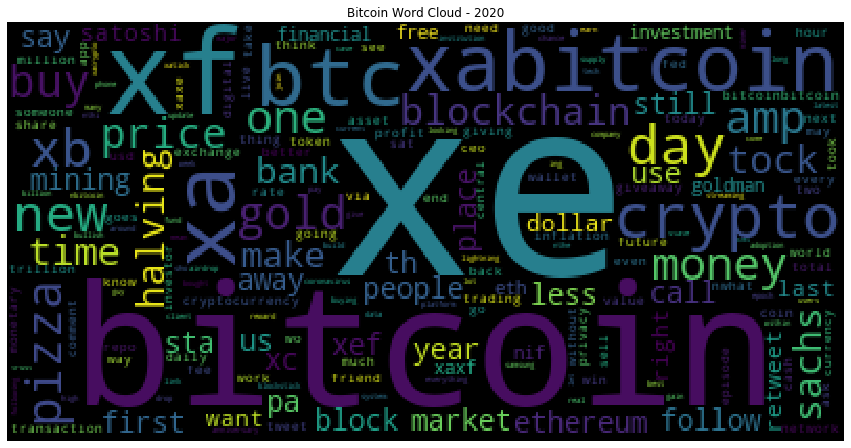

In [9]:
# Visualization using wordcloud for the text
strings = ''
for text in tweets_data['clean_text']:
    strings += text


# Generate a wordcloud image
wordcloud = WordCloud(background_color='black',
                      collocations=False
                     ).generate_from_text(strings)

# Display the image with matplotlib
plt.figure(1,figsize=(15, 12))
plt.imshow(wordcloud)
plt.title('Bitcoin Word Cloud - 2020')
plt.axis('off')
plt.show()

### Visualization

In [10]:
tweets_count = tweets_data['sentiment'].value_counts()
tweets_count

neutral     964
positive    788
negative    268
Name: sentiment, dtype: int64

In [11]:
tweets_data.describe()

,polarity
count,2020.000000
mean,0.107154
std,0.259678
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.211900
max,1.000000


Text(0, 0.5, 'Total Counts')

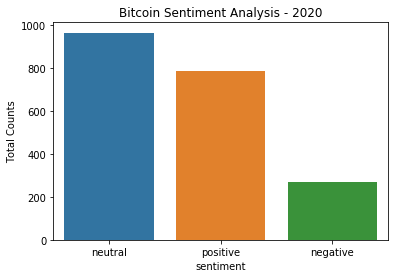

In [12]:
# Plot sentiment mood count
seaborn.countplot(x='sentiment', data=tweets_data)
plt.title('Bitcoin Sentiment Analysis - 2020')
plt.ylabel('Total Counts')

## Sentiment Analysis

In [13]:
for tweet in clean_tweets:
    print(tweet)
    analysis = TextBlob(str(tweet))
    print(analysis.sentiment)
    if analysis.sentiment[0]>0:
       print('Positive')
    elif analysis.sentiment[0]<0:
       print('Negative')
    else:
       print('Neutral')

goldman sachs hosting client call bitcoin gold inflation via
Sentiment(polarity=0.0, subjectivity=0.0)
Neutral
ok president trump endorsing tommy
Sentiment(polarity=0.5, subjectivity=0.5)
Positive
xe bitcoin xf day nwhen btc first used commercial transaction nwhat better place btc atm th xe xa
Sentiment(polarity=0.25, subjectivity=0.27777777777777773)
Positive
great icle nif way could avoided know like minor monthly block red xe xa
Sentiment(polarity=0.25, subjectivity=0.31666666666666665)
Positive
bitcoin btc current price gbp
Sentiment(polarity=0.0, subjectivity=0.4)
Neutral
ea livin truth xe xa
Sentiment(polarity=0.0, subjectivity=0.0)
Neutral
favorite pizza topping mine bitcoin
Sentiment(polarity=0.5, subjectivity=1.0)
Positive
dm fast money crypto cryptocurrency cryptoinvestor dubai cryptocurrencies bitcoin travel litecoi xe xa
Sentiment(polarity=0.2, subjectivity=0.6)
Positive
pay bitcoins couple pizzas like maybe large ones left next day lasz xe xa
Sentiment(polarity=0.071428571

## Save clean tweets to new cleaned dataset

In [14]:
clean_tweets = []
for tweet in tweets_data.text:
    clean_tweets.append(tweet_cleaner(tweet))
tweets_data['clean_text'].to_csv("cleaned_tweet_data.csv", index = False)

C:\cuong\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
